In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.executable

'/mnt/vol_b/miniconda3/envs/fpnsemseg/bin/python'

In [3]:
!nvidia-smi

Thu Apr 27 14:54:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:00:05.0 Off |                  N/A |
|  0%   39C    P5    51W / 350W |      8MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:00:06.0 Off |                  N/A |
|  0%   

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
sys.path.append("..")

In [6]:
CKPT_PATH = "/mnt/vol_b/semgsegfpn/ss_ri_ckpt/epoch=14-step=945.ckpt"

In [7]:
import random
import albumentations as A

from albumentations.pytorch import ToTensorV2

from models.semi_supervised import SemiSupervisedNetwork
from datasets.semis import SemiSupervisedDataset
from semi_supervised_trainer import SegModule

In [16]:
model = SemiSupervisedNetwork()
model.eval()

SemiSupervisedNetwork(
  (b1): FPN(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [9]:
w = {}
for k, v in torch.load(CKPT_PATH)["state_dict"].items():
    w[k[6:]] = v

In [10]:
model.load_state_dict(w)

<All keys matched successfully>

In [11]:
test_set = SemiSupervisedDataset(
            ds_type="test",
            transform1=None,
            transform2=None,
            base_dir="/mnt/vol_b/semgsegfpn/data"
        )

In [12]:
transform=A.Compose([
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
                ToTensorV2(),
            ])

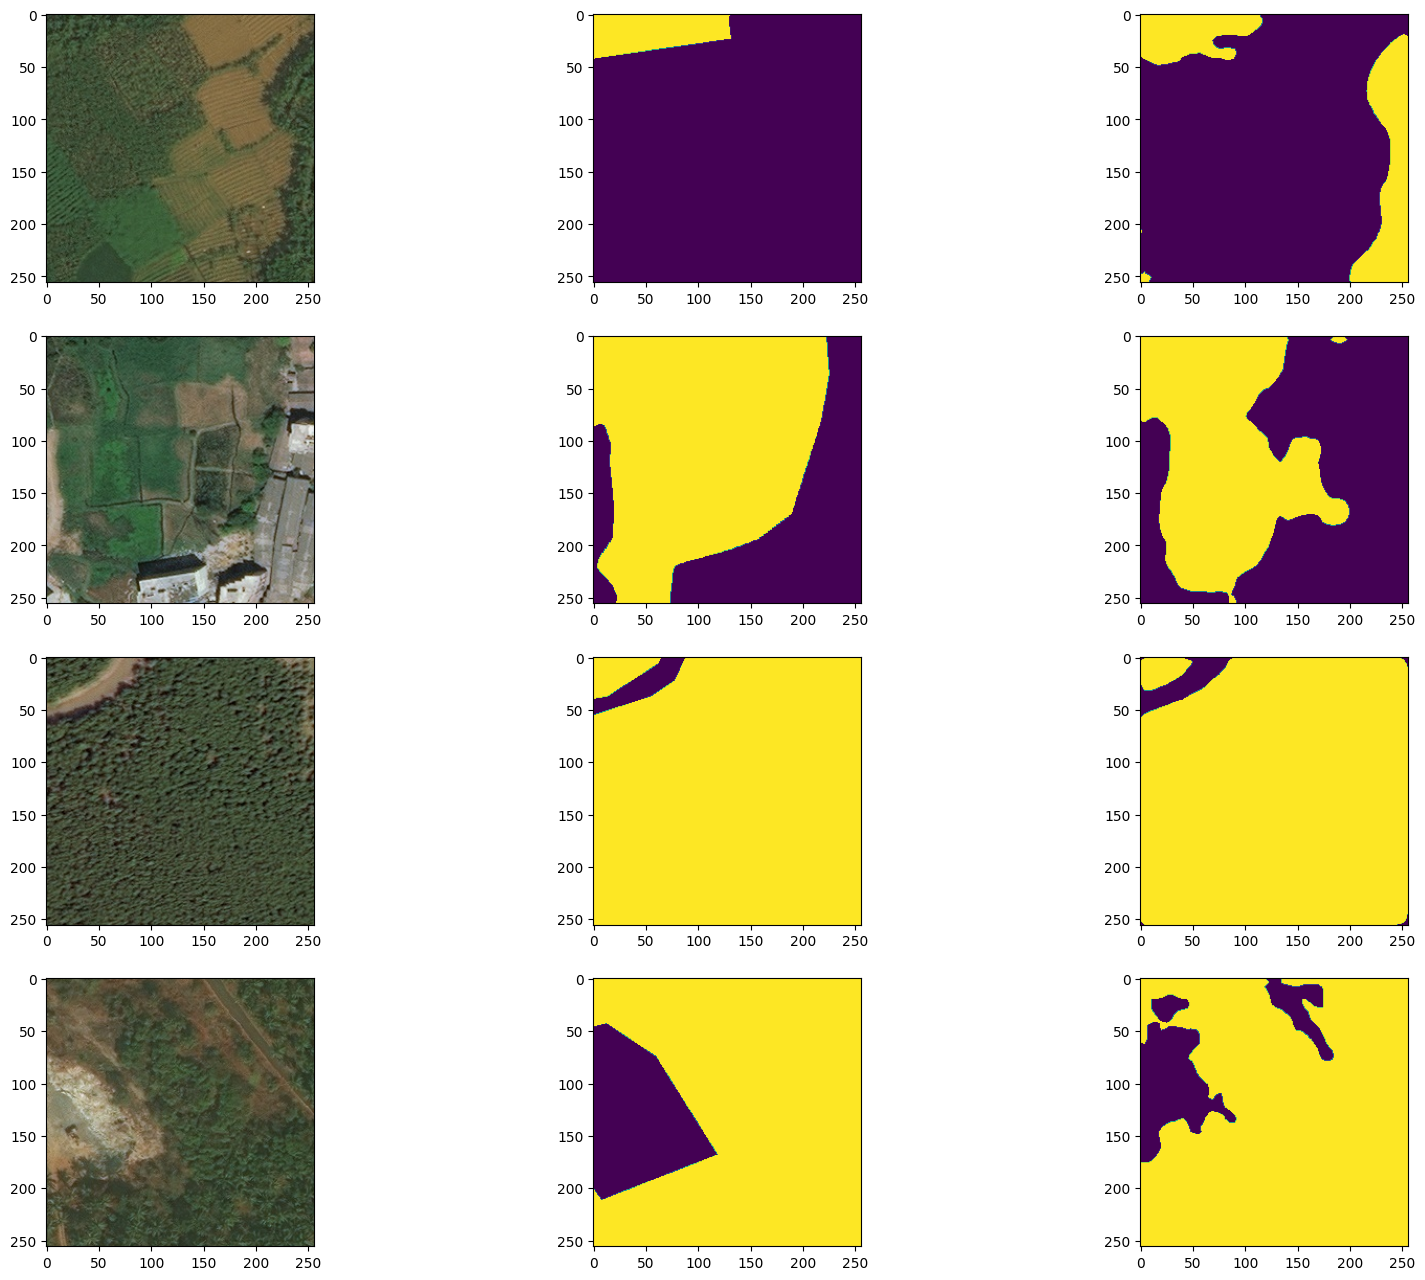

In [20]:
fig, ax = plt.subplots(4, 3, figsize=(20, 16))
for i in range(4):
    idx = random.randint(0, len(test_set))
    
    
    vis_img, gt_mask, _, _ = test_set[idx]
    img = transform(image=vis_img)["image"]
    
    with torch.no_grad():
        pred = model(img[None], training=False).squeeze(1)
        
    ax[i, 0].imshow(vis_img)
    ax[i, 1].imshow(gt_mask)
    ax[i, 2].imshow(pred.sigmoid().round()[0].to(torch.uint8))

## Evaluation

In [8]:
import pytorch_lightning as pl

In [9]:
config = {
        # tune for optimizer block
        "batch_size": 256,
        "lr": 1e-3,
        "patience": 5, 
        "min_lr": 1e-5, 
        "factor": 0.5, 
        "add_noise": 1,
    }

module = SegModule(config=config)
module.load_state_dict(torch.load(CKPT_PATH)["state_dict"])

<All keys matched successfully>

In [10]:
test_set = SemiSupervisedDataset(
            ds_type="test",
            transform1=A.Compose([
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ]), 
            transform2=A.Compose([
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ]),
            base_dir="/mnt/vol_b/semgsegfpn/data"
        )

test_dataloader = torch.utils.data.DataLoader(
            test_set, batch_size=4,
            shuffle=False, pin_memory=True, num_workers=8, drop_last=True
        )

In [21]:
tester = pl.Trainer(
    devices=1,
    accelerator="gpu", 
    enable_progress_bar=True, 
)

tester.test(module, dataloaders=[test_dataloader])